In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/MyDrive/Object Recognition/car_recognition"

/content/drive/MyDrive/Object Recognition/car_recognition


In [5]:
!mkdir "/content/sample_data/car_datasets"
print('Starting create train set')
!unzip "/content/drive/MyDrive/Object Recognition/car_recognition/datasets/smal_train.zip" -d "/content/sample_data/car_datasets" > /dev/null 2>&1
print('Starting create test set')
!unzip "/content/drive/MyDrive/Object Recognition/car_recognition/datasets/smal_test.zip" -d "/content/sample_data/car_datasets" > /dev/null 2>&1
print('Done!')

Starting create train set
Starting create test set
Done!


In [6]:
%matplotlib inline
import os
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json

from data_untils.create_datagenerators import create_data_generators
from data_untils.data_preprocessing import resize_white, resize_black

def printmd(string):
    display(Markdown(string))

In [7]:
# default
SAVE_RESULRS_DIR = '/content/sample_data/saved_weights/'
RESULTS_FOLDER = SAVE_RESULRS_DIR + '20210514_1532'
TRAIN_DIR = '/content/sample_data/car_datasets/train'
TEST_DIR = '/content/sample_data/car_datasets/test'

resize = False


BATCHSIZE = 32

TEST_DIR_TST = TEST_DIR
VALID_DIR_TST = TEST_DIR

In [8]:
def load_image(img_path, input_shape, resize = False):
    if resize:
        img, pth = resize_black(input_shape[1], img_path, print_oldsize=False)
    else:
        img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor


        
def generate_data_generators(input_shape):
    generator_train, generator_test = create_data_generators(input_shape, BATCHSIZE, 
                                                                TRAIN_DIR, TEST_DIR, 
                                                                save_augumented=None, 
                                                                plot_imgs = False)
    return generator_train, generator_test
        
        
def load_model(results_folder):
    # load json and create model
    json_file = open(results_folder + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_folder + "/weights.best.hdf5")
    input_shape = loaded_model.layers[0].output_shape[1:3]
    print("Loaded model from disk")
    return loaded_model, input_shape
       
    
        
def decode_predictions(preds, class_names, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model, input_shape, class_names, correct_class, resize=False, show_imgs=True, top=5):
    img_array = load_image(img_path, input_shape, resize = resize)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names, top=top)
    top1_pred = predictions[0][0]
    #print(predictions)
    #print(correct_class)
    if show_imgs:
        img_org = image.load_img(img_path)
        fig, axs = plt.subplots(1,2)
        axs[0].set_title(correct_class)
        axs[0].imshow(img_org)
        axs[1].set_title(str(top1_pred))
        axs[1].imshow(img_array[0])
        plt.show()
    return predictions
      
        
        
def return_class_names_list(results_folder):
    class_names = []
    # open file and read the content in a list
    with open(results_folder+'/class_names.txt', 'r') as filehandle:  
        for line in filehandle:
            current_line = line[:-1]
            class_names.append(current_line)
    return class_names
        
def perform_pred(loaded_model, resize=False, car_class=None, img_pth=None, show_imgs=True):
    test_dir = TEST_DIR_TST
    results_folder = RESULTS_FOLDER
    
    if os.path.exists(results_folder+'/class_names.txt'):
        class_names = return_class_names_list(results_folder)

    else:
        generator_train, generator_test = generate_data_generators(results_folder, input_shape)
        class_names = list(generator_train.class_indices.keys())
        print(class_names)
        with open(results_folder+'/class_names.txt', 'w') as filehandle:  
            for listitem in class_names:
                filehandle.write('%s\n' % listitem)
                
    if car_class is None:
        car_class = random.choice(class_names)
    
    if img_pth is None: 
        # randomly select an image from defined class     
        test_dir_full = test_dir + '/' + car_class
        test_img = test_dir_full + '/' + random.choice(os.listdir(test_dir_full))
    else:
        test_img = img_pth
        
    
    # input_shape = loaded_model.layers[0].output_shape[1:3]
    input_shape = (224, 224, 3)
          
    predictions = predict(test_img, loaded_model, input_shape, class_names, car_class, resize=resize, show_imgs=show_imgs)
    print(predictions)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

def relu6(x):
    return K.relu(x, max_value=6)

# loaded_model, input_shape=load_model(RESULTS_FOLDER)

loaded_model= load_model(RESULTS_FOLDER + '/weights.best.hdf5',
                  custom_objects = {"relu6": relu6})

generator_train, generator_test = generate_data_generators((224, 224))


Found 8103 images belonging to 195 classes.
Found 8000 images belonging to 195 classes.


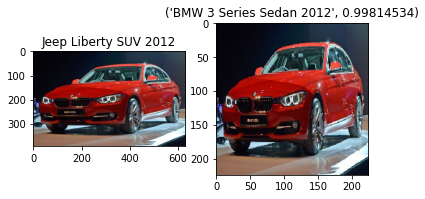

[[('BMW 3 Series Sedan 2012', 0.99814534), ('BMW X3 SUV 2012', 0.0007155287), ('BMW 3 Series Wagon 2012', 0.0005233178), ('Dodge Durango SUV 2012', 0.00020724104), ('BMW M5 Sedan 2010', 0.0001124811)]]


In [ ]:
path_img = TEST_DIR + '/'+'/BMW 3 Series Sedan 2012'+'/01631.jpg'

perform_pred(loaded_model, resize=False, car_class=None, img_pth=path_img, show_imgs=True)

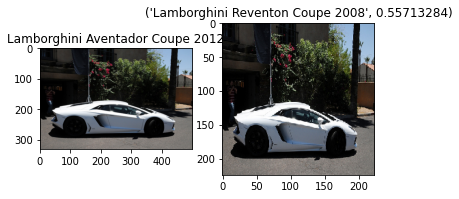

[[('Lamborghini Reventon Coupe 2008', 0.55713284), ('Lamborghini Aventador Coupe 2012', 0.3799516), ('Ford GT Coupe 2006', 0.047547176), ('Audi R8 Coupe 2012', 0.010160672), ('Mercedes-Benz SL-Class Coupe 2009', 0.0009857791)]]


In [ ]:
perform_pred(loaded_model, resize=False, car_class='Lamborghini Aventador Coupe 2012', img_pth=None, show_imgs=True)

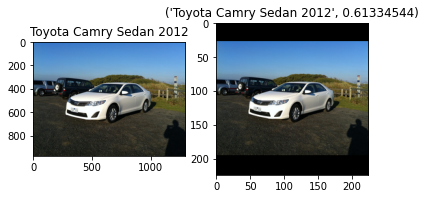

[[('Toyota Camry Sedan 2012', 0.61334544), ('Ford Fiesta Sedan 2012', 0.28335726), ('Audi R8 Coupe 2012', 0.023648914), ('Bugatti Veyron 16.4 Coupe 2009', 0.02094052), ('Bugatti Veyron 16.4 Convertible 2009', 0.020242644)]]


In [ ]:
perform_pred(loaded_model, resize=True, car_class=None, img_pth=None, show_imgs=True)

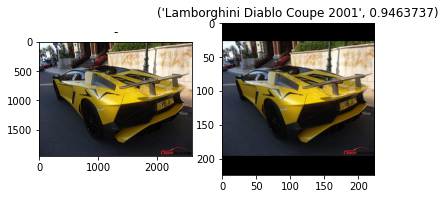

[[('Lamborghini Diablo Coupe 2001', 0.9463737), ('Lamborghini Gallardo LP 570-4 Superleggera 2012', 0.05151494), ('Ford GT Coupe 2006', 0.0018431019), ('BMW M5 Sedan 2010', 0.00011505536), ('Lamborghini Reventon Coupe 2008', 4.838455e-05)]]


In [ ]:
img_path = '/content/drive/MyDrive/Car Recognition/Code/datasets/test/lamborghini-aventador-4.jpg'
perform_pred(loaded_model, resize=True, car_class='-', img_pth=img_path, show_imgs=True)